1. SCRAPER
- save all things into a database
    - table product_history: timestamp, product, our current price, (COMPUTE) lowest price, lowest price holder, compute lowest (COMPUTE) total cost, our stock status 
    - table vendor_history: timestamp, vendor, compute bayesian average review
    - table potential decrease: product, competitor, our price, lowest price, our total cost, lowest total cost
                 
2. DASHBOARD
    - show potential price decrease items         
    - show list of things running low on stock/out of stock - ideally groupby categories
    - show our customer review score change    
    
- make it into a docker image

In [28]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import config_ as c

## Load data and process

### Data ingestion

In [29]:
product_data_pd = pd.read_html(c.PRODUCT_DATA_URL, index_col="Unnamed: 0")[0]
product_data_pd['Item'] = product_data_pd['Item'].astype("string")
product_data_pd['Category'] = product_data_pd['Category'].astype("string")
product_data_pd['Vendor'] = product_data_pd['Vendor'].astype("string")
product_data_pd['Sale Price'] = pd.to_numeric(product_data_pd['Sale Price'], errors="raise")
product_data_pd['Stock Status'] = product_data_pd['Stock Status'].astype("string")
product_data_pd['Subcategory'] = product_data_pd['Item'].str.extract(r'([a-zA-Z\s]+)', expand=False).str.strip()

print(product_data_pd)

             Item     Category            Vendor  Sale Price  Stock Status  \
0    Smartphone 1  Electronics      ElectroWorld      522.74      In Stock   
1    Smartphone 1  Electronics  MantaElectronics     1316.25      In Stock   
2    Smartphone 1  Electronics    GadgetUniverse      365.80      In Stock   
3    Smartphone 1  Electronics         TechGiant      605.80     Low Stock   
4    Smartphone 1  Electronics        TechSphere      517.26     Low Stock   
..            ...          ...               ...         ...           ...   
995     Laptop 19  Electronics        Innovatech     1213.26      In Stock   
996     Laptop 19  Electronics    GadgetUniverse      761.30  Out of Stock   
997     Laptop 19  Electronics         TechGiant     1101.92     Low Stock   
998     Laptop 19  Electronics      ElectroBuddy     1339.84     Low Stock   
999     Laptop 19  Electronics      ElectroWorld      490.56  Out of Stock   

    Subcategory  
0    Smartphone  
1    Smartphone  
2    Smar

In [30]:
vendor_data_pd = pd.read_html(c.VENDOR_DATA_URL, index_col="Unnamed: 0")[0]
vendor_data_pd['Vendor Name'] = vendor_data_pd['Vendor Name'].astype("string")
vendor_data_pd['Shipping Cost'] = pd.to_numeric(vendor_data_pd['Shipping Cost'], errors="raise")
vendor_data_pd['Customer Review Score'] = pd.to_numeric(vendor_data_pd['Customer Review Score'], errors="raise")
vendor_data_pd['Number of Feedbacks'] = pd.to_numeric(vendor_data_pd['Number of Feedbacks'], errors="raise")
vendor_data_pd.rename(columns={"Vendor Name": "Vendor"}, inplace=True)
print(vendor_data_pd)

             Vendor  Shipping Cost  Customer Review Score  Number of Feedbacks
0         TechGiant             10               1.386629                  270
1      ElectroWorld              7               2.599227                  167
2    GadgetUniverse              6               1.945218                  424
3        Innovatech             14               1.526953                    9
4        TechSphere              5               2.959031                   78
5  MantaElectronics              7               1.748223                  437
6      ElectroBuddy             10               3.135381                  407


### Compute Bayesian review

In [31]:
C = vendor_data_pd["Customer Review Score"].mean()
m = 100

vendor_data_pd["Bayesian Average"] = (vendor_data_pd["Number of Feedbacks"]/(vendor_data_pd["Number of Feedbacks"]+m))*vendor_data_pd["Customer Review Score"] + (m/(vendor_data_pd["Number of Feedbacks"]+m))*C

vendor_history_table_increment = vendor_data_pd[["Vendor", "Bayesian Average"]]
vendor_history_table_increment["DateTime"] = pd.Timestamp("now", tz=dt.timezone.utc)

vendor_history_table_increment

C:\Users\vojte\AppData\Local\Temp\ipykernel_23152\2406527599.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendor_history_table_increment["DateTime"] = pd.Timestamp("now", tz=dt.timezone.utc)


,Vendor,Bayesian Average,DateTime
0,TechGiant,1.602624,2024-04-10 16:07:10.932594+00:00
1,ElectroWorld,2.444389,2024-04-10 16:07:10.932594+00:00
2,GadgetUniverse,1.991132,2024-04-10 16:07:10.932594+00:00
3,Innovatech,2.131408,2024-04-10 16:07:10.932594+00:00
4,TechSphere,2.524637,2024-04-10 16:07:10.932594+00:00
5,MantaElectronics,1.829710,2024-04-10 16:07:10.932594+00:00
6,ElectroBuddy,2.948089,2024-04-10 16:07:10.932594+00:00


In [32]:
product_history_table_increment = product_data_pd[product_data_pd["Vendor"] == c.MY_VENDOR_NAME][["Subcategory", "Item", "Stock Status", "Sale Price"]].reset_index()
product_history_table_increment.rename(columns={"Stock Status" : "Our Stock Status", "Sale Price" : "Our Sale Price"}, inplace=True)

# Add lowest price
tmp_table = product_data_pd.loc[product_data_pd.groupby('Item')["Sale Price"].idxmin()][["Item", "Vendor", "Sale Price"]]
tmp_table.rename(columns={"Sale Price": "Lowest Sale Price", "Vendor": "Lowest Sale Price Vendor"}, inplace=True)
product_history_table_increment = product_history_table_increment.merge(tmp_table, on="Item", how="left")
product_history_table_increment["Our Sale Price Excess"] = product_history_table_increment["Our Sale Price"] - product_history_table_increment["Lowest Sale Price"]

# Add lowest total cost
product_data_pd = product_data_pd.merge(vendor_data_pd[["Vendor", "Shipping Cost"]], on="Vendor", how="left")
product_data_pd["Total Cost"] = product_data_pd["Sale Price"] + product_data_pd["Shipping Cost"]
tmp_table_2 = product_data_pd.loc[product_data_pd.groupby('Item')["Total Cost"].idxmin()][["Item", "Total Cost", "Vendor"]]
tmp_table_2.rename(columns={"Total Cost": "Lowest Total Cost", "Vendor": "Lowest Total Cost Vendor"}, inplace=True)
product_history_table_increment = product_history_table_increment.merge(tmp_table_2, on="Item", how="left")
product_history_table_increment["Our Total Cost Excess"] = product_history_table_increment["Our Sale Price"] + vendor_data_pd[vendor_data_pd["Vendor"]=="ElectroWorld"]["Shipping Cost"].item() - product_history_table_increment["Lowest Total Cost"]

# Add timestamp
product_history_table_increment["DateTime"] = pd.Timestamp("now", tz=dt.timezone.utc)

# Drop index column
product_history_table_increment.drop(columns=["index"], inplace=True)

In [33]:
product_history_table_increment

,Subcategory,Item,Our Stock Status,Our Sale Price,Lowest Sale Price Vendor,Lowest Sale Price,Our Sale Price Excess,Lowest Total Cost,Lowest Total Cost Vendor,Our Total Cost Excess,DateTime
0,Smartphone,Smartphone 1,In Stock,522.74,GadgetUniverse,365.80,156.94,371.80,GadgetUniverse,157.94,2024-04-10 16:07:11.047598+00:00
1,Headphones,Headphones 1,Out of Stock,358.05,TechSphere,184.44,173.61,189.44,TechSphere,175.61,2024-04-10 16:07:11.047598+00:00
2,Smartwatch,Smartwatch 1,In Stock,1076.32,TechGiant,753.60,322.72,763.60,TechGiant,319.72,2024-04-10 16:07:11.047598+00:00
3,Tablet,Tablet 1,Out of Stock,777.00,Innovatech,215.84,561.16,229.84,Innovatech,554.16,2024-04-10 16:07:11.047598+00:00
4,Drone,Drone 1,In Stock,1213.42,GadgetUniverse,304.29,909.13,310.29,GadgetUniverse,910.13,2024-04-10 16:07:11.047598+00:00
...,...,...,...,...,...,...,...,...,...,...,...
129,Printer,Printer 18,Out of Stock,333.25,TechGiant,196.35,136.90,206.35,TechGiant,133.90,2024-04-10 16:07:11.047598+00:00
130,Monitor,Monitor 18,Low Stock,443.70,Innovatech,83.74,359.96,97.74,Innovatech,352.96,2024-04-10 16:07:11.047598+00:00
131,Mouse,Mouse 18,Low Stock,921.30,TechSphere,404.80,516.50,409.80,TechSphere,518.50,2024-04-10 16:07:11.047598+00:00
132,Smartphone,Smartphone 19,Out of Stock,1045.45,TechGiant,218.50,826.95,228.50,TechGiant,823.95,2024-04-10 16:07:11.047598+00:00


In [34]:
vendor_history_table_increment

,Vendor,Bayesian Average,DateTime
0,TechGiant,1.602624,2024-04-10 16:07:10.932594+00:00
1,ElectroWorld,2.444389,2024-04-10 16:07:10.932594+00:00
2,GadgetUniverse,1.991132,2024-04-10 16:07:10.932594+00:00
3,Innovatech,2.131408,2024-04-10 16:07:10.932594+00:00
4,TechSphere,2.524637,2024-04-10 16:07:10.932594+00:00
5,MantaElectronics,1.829710,2024-04-10 16:07:10.932594+00:00
6,ElectroBuddy,2.948089,2024-04-10 16:07:10.932594+00:00


In [35]:
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, DateTime, Float

# Create a SQLAlchemy engine
engine = create_engine(c.DATABASE_PATH, echo=True)

# Define metadata
metadata = MetaData()

# Define your tables
table1 = Table(
    'product_history_table_increment',
    metadata,    
    Column('ID', Integer, primary_key=True),
    Column('Subcategory', String),
    Column('Item', String),
    Column('Our Stock Status', String),
    Column('Our Sale Price', Float),
    Column('Lowest Sale Price Vendor', String),
    Column('Lowest Sale Price', Float),
    Column('Our Sale Price Excess', Float),
    Column('Lowest Total Cost', Float),
    Column('Lowest Total Cost Vendor', String),
    Column('Our Total Cost Excess', Float),
    Column('DateTime', DateTime)    
)

table2 = Table(
    'vendor_history_table_increment',
    metadata,
    Column('ID', Integer, primary_key=True),
    Column('Vendor', String),
    Column('Bayesian Average', Float),
    Column('DateTime', DateTime)
)

# Create all tables in the database
metadata.create_all(engine)

2024-04-10 18:07:11,200 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-10 18:07:11,206 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("product_history_table_increment")
2024-04-10 18:07:11,210 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:11,222 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("vendor_history_table_increment")
2024-04-10 18:07:11,223 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:11,226 INFO sqlalchemy.engine.Engine COMMIT


In [36]:
from sqlalchemy import create_engine

engine = create_engine(c.DATABASE_PATH, echo=True)

# Store dfs in the database
product_history_table_increment.to_sql('product_history_table_increment', con=engine, if_exists='replace', index=False)
vendor_history_table_increment.to_sql('vendor_history_table_increment', con=engine, if_exists='append', index=False)

2024-04-10 18:07:25,550 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-10 18:07:25,567 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("product_history_table_increment")
2024-04-10 18:07:25,569 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:25,573 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("product_history_table_increment")
2024-04-10 18:07:25,575 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:25,578 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-04-10 18:07:25,580 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:25,585 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-04-10 18:07:25,587 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:25,593 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("product_history_table_increment")
2024-04

7

In [37]:
from sqlalchemy import inspect

# Create an inspector
inspector = inspect(engine)

# Get the names of all tables in the database
table_names = inspector.get_table_names()

# Iterate through each table and print the column names
for table_name in table_names:
    print("Table:", table_name)
    columns = inspector.get_columns(table_name)
    for column in columns:
        print("Column:", column["name"])

2024-04-10 18:07:26,607 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-10 18:07:26,609 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-04-10 18:07:26,611 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:26,613 INFO sqlalchemy.engine.Engine ROLLBACK
Table: existing_table_name
2024-04-10 18:07:26,615 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-10 18:07:26,616 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("existing_table_name")
2024-04-10 18:07:26,617 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:26,619 INFO sqlalchemy.engine.Engine ROLLBACK
Column: Vendor
Column: Bayesian Average
Column: Timestamp
Table: product_history_table_increment
2024-04-10 18:07:26,622 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-10 18:07:26,623 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("product_history_table_increment")
2024-04-10 18:07:26,624 INFO s

In [38]:
import pandas as pd

# Read data from a table into a DataFrame
df = pd.read_sql_table('vendor_history_table_increment', engine)

# Print the first few rows of the DataFrame
df

2024-04-10 18:07:27,008 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-10 18:07:27,010 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("vendor_history_table_increment")
2024-04-10 18:07:27,012 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:27,014 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-04-10 18:07:27,016 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:27,018 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-04-10 18:07:27,020 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:27,022 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("vendor_history_table_increment")
2024-04-10 18:07:27,023 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-04-10 18:07:27,025 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * 

,ID,Vendor,Bayesian Average,DateTime
0,1,TechGiant,1.602624,2024-04-10 14:56:08.746709
1,2,ElectroWorld,2.444389,2024-04-10 14:56:08.746709
2,3,GadgetUniverse,1.991132,2024-04-10 14:56:08.746709
3,4,Innovatech,2.131408,2024-04-10 14:56:08.746709
4,5,TechSphere,2.524637,2024-04-10 14:56:08.746709
5,6,MantaElectronics,1.829710,2024-04-10 14:56:08.746709
6,7,ElectroBuddy,2.948089,2024-04-10 14:56:08.746709
7,8,TechGiant,1.602624,2024-04-10 14:56:08.746709
8,9,ElectroWorld,2.444389,2024-04-10 14:56:08.746709
9,10,GadgetUniverse,1.991132,2024-04-10 14:56:08.746709


# VISUALIZATION

In [6]:
product_history_table_increment[product_history_table_increment["Lowest Sale Price Vendor"] != c.MY_VENDOR_NAME].groupby(["Subcategory"])["Our Sale Price Excess"].mean().sort_values(ascending=False)

Subcategory
Laptop        682.736364
Monitor       658.971250
Smartphone    649.465000
Mouse         554.580000
Headphones    532.536154
Smartwatch    516.990000
Keyboard      513.640000
Drone         392.982500
Tablet        371.491111
Camera        344.081429
Printer       310.207143
Name: Our Sale Price Excess, dtype: float64

In [7]:
product_history_table_increment[product_history_table_increment["Lowest Sale Price Vendor"] != c.MY_VENDOR_NAME][["Subcategory", "Item", "Our Sale Price", "Lowest Sale Price", "Lowest Sale Price Vendor", "Our Sale Price Excess", "Our Total Cost Excess"]].sort_values("Our Sale Price Excess", ascending=False)

,Subcategory,Item,Our Sale Price,Lowest Sale Price,Lowest Sale Price Vendor,Our Sale Price Excess,Our Total Cost Excess
6,Keyboard,Keyboard 1,1607.19,235.42,Innovatech,1371.77,1364.77
59,Laptop,Laptop 9,1438.40,130.29,ElectroBuddy,1308.11,1305.11
107,Smartphone,Smartphone 16,1368.06,81.95,ElectroBuddy,1286.11,1283.11
54,Headphones,Headphones 8,1432.77,271.35,TechGiant,1161.42,1158.42
118,Laptop,Laptop 17,1251.66,93.94,TechGiant,1157.72,1154.72
...,...,...,...,...,...,...,...
26,Drone,Drone 4,414.40,395.16,TechGiant,19.24,16.24
127,Camera,Camera 18,229.87,212.16,ElectroBuddy,17.71,14.71
71,Keyboard,Keyboard 10,560.88,547.52,TechSphere,13.36,15.36
109,Headphones,Headphones 16,556.26,548.24,MantaElectronics,8.02,8.02


In [8]:
product_history_table_increment[(product_history_table_increment["Our Stock Status"] == "Out of Stock") | (product_history_table_increment["Our Stock Status"] == "Low Stock")][["Item", "Our Stock Status", "Subcategory"]].groupby(["Subcategory", "Our Stock Status"]).count()

Item
Subcategory Our Stock Status      
Camera      Low Stock            2
            Out of Stock         3
Drone       Low Stock            2
            Out of Stock         5
Headphones  Low Stock            4
            Out of Stock         8
Keyboard    Low Stock            3
            Out of Stock         5
Laptop      Low Stock            6
            Out of Stock         2
Monitor     Low Stock            4
            Out of Stock         2
Mouse       Low Stock            6
            Out of Stock         2
Printer     Low Stock            7
            Out of Stock         3
Smartphone  Low Stock            6
            Out of Stock         7
Smartwatch  Low Stock            5
            Out of Stock         2
Tablet      Low Stock            8
            Out of Stock         2

In [9]:
product_history_table_increment[(product_history_table_increment["Our Stock Status"] == "Out of Stock") | (product_history_table_increment["Our Stock Status"] == "Low Stock")][["Item", "Our Stock Status"]]

,Item,Our Stock Status
1,Headphones 1,Out of Stock
3,Tablet 1,Out of Stock
5,Printer 1,Low Stock
8,Headphones 2,Out of Stock
9,Tablet 2,Low Stock
...,...,...
129,Printer 18,Out of Stock
130,Monitor 18,Low Stock
131,Mouse 18,Low Stock
132,Smartphone 19,Out of Stock


<Axes: xlabel='Timestamp'>

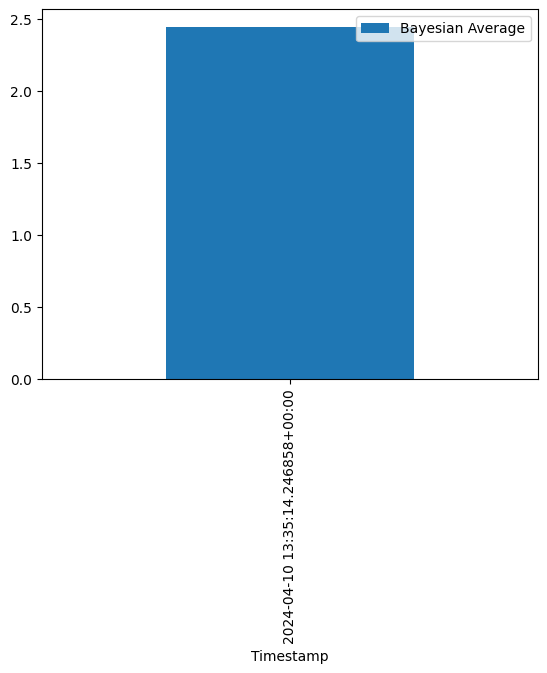

In [10]:
vendor_history_table_increment[vendor_history_table_increment["Vendor"] == c.MY_VENDOR_NAME].set_index("Timestamp").sort_values("Timestamp").plot(kind="bar")